In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("Datasets/training.csv")
test = pd.read_csv('Datasets/test.csv')
validation = pd.read_csv('Datasets/validation.csv')

Labels :

  * 0 = sadness
  * 1 = joy
  * 2 = love
  * 3 = anger
  * 4 = fear
  * 5 = surprise

In [3]:
train.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


In [5]:
validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [7]:
def replace_label(df):
    df['label'] = df['label'].replace({0: 0, 1: 1, 2: 1, 3: 3, 4: 3 , 5: 5}) 

0 = sadness
1 = joy or love
3 = confus
4 = surpris

In [8]:
replace_label(train)
replace_label(test)
replace_label(validation)

## Visualisation

<Axes: xlabel='label', ylabel='count'>

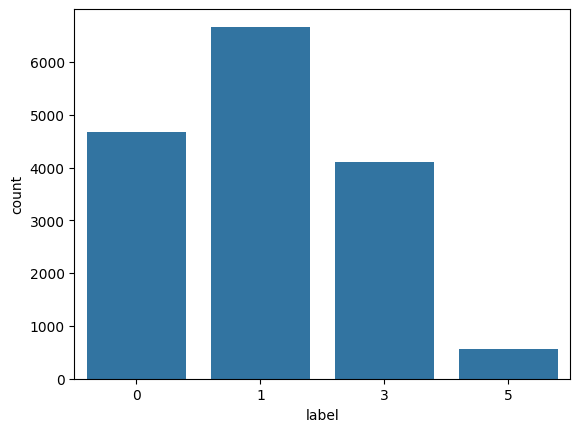

In [9]:
sns.countplot(x='label',data=train)

<Axes: xlabel='label', ylabel='count'>

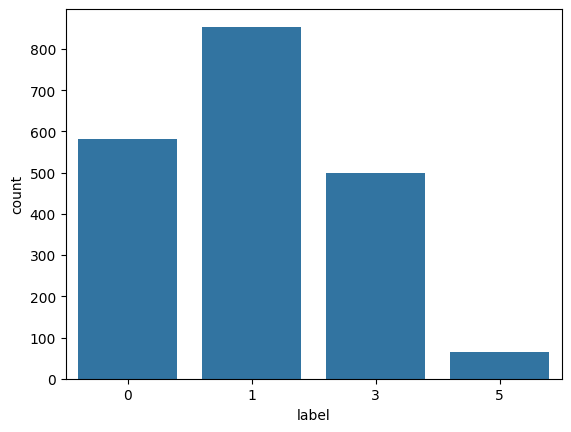

In [10]:
sns.countplot(x='label',data=test)

<Axes: xlabel='label', ylabel='count'>

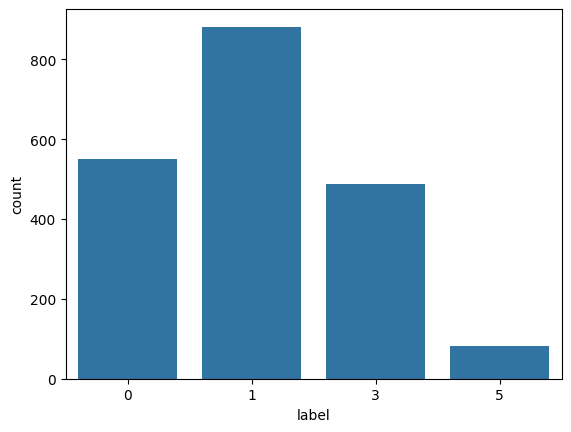

In [11]:
sns.countplot(x='label',data=validation)

On peut conclure que la répartitions des données par catégories est semblable pour tous les datasets sachant qu'il y a une prédominance des données de catégories 0 et 1.

## Data Preprocessing

In [12]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# 
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\perri\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\perri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\perri\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\perri\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [15]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in ['feel', 'feeling']]
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [str(lemmatizer.lemmatize(token)) for token in filtered_tokens]
    return lemmatized_tokens

In [16]:
train['text'] = train['text'].apply(preprocess_text)

In [17]:
test['text'] = test['text'].apply(preprocess_text)
validation['text'] = validation['text'].apply(preprocess_text)

In [18]:

print(train.text.iloc[0])

['didnt', 'humiliated']


In [19]:
train.head()

,text,label
0,"[didnt, humiliated]",0
1,"[go, hopeless, damned, hopeful, around, someon...",0
2,"[im, grabbing, minute, post, greedy, wrong]",3
3,"[ever, nostalgic, fireplace, know, still, prop...",1
4,[grouchy],3


In [1]:
test.head()

NameError: name 'test' is not defined

In [21]:
validation.head()

,text,label
0,"[im, quite, sad, sorry, ill, snap, soon]",0
1,"[like, still, looking, blank, canvas, blank, p...",0
2,"[like, faithful, servant]",1
3,"[cranky, blue]",3
4,"[treat, festive]",1


In [22]:
from gensim.models import Word2Vec

model = Word2Vec(sentences=train['text'], min_count=25, vector_size=600, window=8, workers=10, epochs=100)
model.train(train['text'], total_examples=len(train['text']), epochs=100)
print(model.wv.most_similar('god'))

[('side', 0.17676278948783875), ('long', 0.17415721714496613), ('sincere', 0.16998985409736633), ('touch', 0.16434913873672485), ('letting', 0.16252882778644562), ('guilty', 0.15901614725589752), ('mother', 0.1589120626449585), ('personally', 0.15210723876953125), ('chance', 0.1487078219652176), ('abused', 0.1457328498363495)]


In [23]:
def vectorize_text(text, model):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)
    
train_vectors = train['text'].apply(lambda x: vectorize_text(x, model))
test_vectors = test['text'].apply(lambda x: vectorize_text(x, model))
validation_vectors = validation['text'].apply(lambda x: vectorize_text(x, model))

X_train = np.vstack(train_vectors)
X_test = np.vstack(test_vectors)
X_validation = np.vstack(validation_vectors)

y_train = train['label']
y_test = test['label']
y_validation = validation['label']

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

rf_logistic = LogisticRegression(random_state=42)
rf_logistic.fit(X_train, y_train)


y_pred_lg = rf_logistic.predict(X_test)
print(f'Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lg)}')
print(classification_report(y_test, y_pred_lg))
print(confusion_matrix(y_test, y_pred_lg))


Logistic Regression Accuracy: 0.7825
              precision    recall  f1-score   support

           0       0.77      0.73      0.75       581
           1       0.82      0.88      0.85       854
           3       0.73      0.72      0.73       499
           5       0.72      0.52      0.60        66

    accuracy                           0.78      2000
   macro avg       0.76      0.71      0.73      2000
weighted avg       0.78      0.78      0.78      2000

[[423  87  71   0]
 [ 57 749  44   4]
 [ 70  61 359   9]
 [  1  16  15  34]]


c:\Users\perri\Desktop\WORKSPACE\Sentiment analysis\mon_env\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [25]:
def predict_sentiment(model):
    # Nouvelle phrase à prédire
    new_sentence = input('Entrez une phrase : ')

    # Étape 1 : Prétraiter la phrase
    preprocessed_sentence = preprocess_text(new_sentence)

    # Étape 2 : Vectoriser la phrase
    sentence_vector = vectorize_text(preprocessed_sentence, model)

    # Étape 3 : Prédire le label avec les modèles entraînés
    predicted_label_rf = rf_logistic.predict([sentence_vector])
    # predicted_label_svc = svc_classifier.predict([sentence_vector])

    # Afficher le résultat
    print(f'Predicted label by Logistic: {predicted_label_rf[0]}')
    # print(f'Predicted label by SVC: {predicted_label_svc[0]}')

In [26]:
predict_sentiment(model)

Predicted label by Logistic: 1


In [27]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)


y_pred_rf = rf_classifier.predict(X_test)
print(f'RandomForestClassifier Accuracy: {accuracy_score(y_test, y_pred_rf)}')
print(classification_report(y_test, y_pred_rf))


RandomForestClassifier Accuracy: 0.651
              precision    recall  f1-score   support

           0       0.68      0.53      0.60       581
           1       0.62      0.92      0.74       854
           3       0.74      0.41      0.53       499
           5       0.50      0.03      0.06        66

    accuracy                           0.65      2000
   macro avg       0.64      0.47      0.48      2000
weighted avg       0.66      0.65      0.62      2000



In [28]:
print(confusion_matrix(y_test, y_pred_rf))

[[307 231  43   0]
 [ 43 788  21   2]
 [ 87 207 205   0]
 [ 12  43   9   2]]


In [29]:
from sklearn.svm import SVC

svc_classifier = SVC()
svc_classifier.fit(X_train, y_train)

# Prédiction et évaluation
y_pred_svc = svc_classifier.predict(X_test)
print(f'SVC Accuracy: {accuracy_score(y_test, y_pred_svc)}')
print(classification_report(y_test, y_pred_svc))


SVC Accuracy: 0.815
              precision    recall  f1-score   support

           0       0.81      0.78      0.79       581
           1       0.83      0.92      0.87       854
           3       0.80      0.74      0.77       499
           5       0.89      0.36      0.52        66

    accuracy                           0.81      2000
   macro avg       0.83      0.70      0.74      2000
weighted avg       0.82      0.81      0.81      2000



In [30]:
y_pred_validation_rf = rf_classifier.predict(X_validation)
print(f'RandomForestClassifier Validation Accuracy: {accuracy_score(y_validation, y_pred_validation_rf)}')
print(classification_report(y_validation, y_pred_validation_rf))

y_pred_validation_svc = svc_classifier.predict(X_validation)
print(f'SVC Validation Accuracy: {accuracy_score(y_validation, y_pred_validation_svc)}')
print(classification_report(y_validation, y_pred_validation_svc))

RandomForestClassifier Validation Accuracy: 0.6355
              precision    recall  f1-score   support

           0       0.64      0.53      0.58       550
           1       0.62      0.91      0.74       882
           3       0.72      0.36      0.48       487
           5       0.75      0.04      0.07        81

    accuracy                           0.64      2000
   macro avg       0.68      0.46      0.47      2000
weighted avg       0.65      0.64      0.60      2000

SVC Validation Accuracy: 0.809
              precision    recall  f1-score   support

           0       0.79      0.78      0.78       550
           1       0.83      0.91      0.86       882
           3       0.79      0.72      0.75       487
           5       0.88      0.47      0.61        81

    accuracy                           0.81      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.81      0.81      0.81      2000



In [32]:
def predict_sentiment(model):
    # Nouvelle phrase à prédire
    new_sentence = input('Entrez une phrase : ')

    # Étape 1 : Prétraiter la phrase
    preprocessed_sentence = preprocess_text(new_sentence)

    # Étape 2 : Vectoriser la phrase
    sentence_vector = vectorize_text(preprocessed_sentence, model)

    # Étape 3 : Prédire le label avec les modèles entraînés
    predicted_label_rf = svc_classifier.predict([sentence_vector])
    # predicted_label_svc = svc_classifier.predict([sentence_vector])

    # Afficher le résultat
    print(f'Predicted label by SVC: {predicted_label_rf[0]}')
    # print(f'Predicted label by SVC: {predicted_label_svc[0]}')

In [35]:
predict_sentiment(model)

Predicted label by SVC: 1


In [36]:
import pickle

with open('modele.pkl', 'wb') as fichier_modele:
    pickle.dump(model, fichier_modele)

In [37]:
with open('svc_classifer.pkl', 'wb') as fichier_modele:
    pickle.dump(svc_classifier, fichier_modele)

In [38]:
with open('logistic.pkl', 'wb') as fichier_modele:
    pickle.dump(rf_logistic, fichier_modele)

In [31]:
# models = [LogisticRegression(random_state=42), DecisionTreeClassifier(criterion='entropy'), RandomForestClassifier(), XGBClassifier()]

#for model in models:

    #print(f'________________{model}')
    #model.fit(X_train, y_train)
    #y_pred = model.predict(X_val)
    #print(f'Confusion matrix: {confusion_matrix(y_val, y_pred)}')
    #print(f'Accuracy : {accuracy_score(y_val, y_pred)}')
    #print(f'Classification Report : {classification_report(y_val, y_pred)}')